## Example 1

['0:[f20<16.8199997] yes=1,no=2,missing=2\n'
 '\t1:[f27<0.135700002] yes=3,no=4,missing=4\n'
 '\t\t3:leaf=0.455090463\n'
 '\t\t4:leaf=-0.258650124\n'
 '\t2:[f21<19.5900002] yes=5,no=6,missing=6\n'
 '\t\t5:leaf=-0.0975049734\n'
 '\t\t6:leaf=-0.76574719\n']


Tree                                               0
Node                                               3
Feature                                          f27
Sign                                               <
Split                                         0.1357
Count                                          332.0
CountPct                                     0.58348
NonEvents                                        5.0
Events                                         327.0
EventRate                                    0.98494
WOE                                         3.659373
IV                                          3.265556
XAddEvidence                                 0.45509
DetailedSplit    f20 < 16.8199997, f27 < 0.135700002
Name: 0, dtype: object

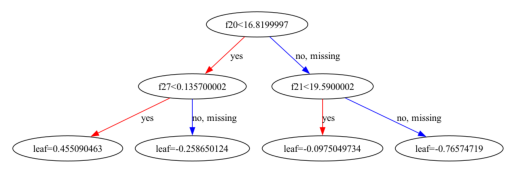

In [1]:
import json
from pprint import pprint

import numpy as np
import xgboost as xgb
from scipy.special import logit
from sklearn.datasets import load_breast_cancer
from xgboost import plot_tree
from xbooster.constructor import XGBScorecardConstructor


def extract_model_param(booster, param):
    """
    Extracts a specific parameter from the XGBoost model configuration.

    Args:
        param (str): The name of the parameter to extract.

    Returns:
        float: The extracted parameter value.
    """
    config = json.loads(booster.save_config())
    if param == "base_score":
        return float(config["learner"]["learner_model_param"][param])
    return float(config["learner"]["gradient_booster"]["tree_train_param"][param])


# Load data
data = load_breast_cancer()
X, y = data.data, data.target
n_rounds = 2

# Fit model
model = xgb.XGBClassifier(n_estimators=n_rounds, max_depth=2, eval_metric="logloss")
model.fit(X, y)

# Get booster object
booster = model.get_booster()
base_score = extract_model_param(booster, "base_score")

# Plot a tree
tree_idx = 0
plot_tree(booster, num_trees=tree_idx)
# Print dump from tree 1
pprint(booster[tree_idx].get_dump())


scorecard_constructor = XGBScorecardConstructor(model, X, y)
scorecard_constructor.base_score

# Build scorecard
scorecard_constructor.construct_scorecard().query(f"Tree == {tree_idx}").iloc[0]

In [2]:
def calculate_results(booster, X, base_score, logit_scale=True):
    # Use logit to inverse the base score back to raw leaf value (margin)
    scores = np.full((X.shape[0],), logit(base_score) if logit_scale else base_score)
    for i in range(n_rounds):
        # - Use output_margin to get raw leaf values
        # - Use iteration_range to get prediction for only one tree
        # - Use previous prediction as base margin for the model
        Xy_test = xgb.DMatrix(X, base_margin=scores)

        if i == n_rounds - 1:
            # last round, get the transformed prediction
            scores = booster.predict(Xy_test, iteration_range=(i, i + 1), output_margin=False)
        else:
            # get raw leaf value for accumulation
            scores = booster.predict(Xy_test, iteration_range=(i, i + 1), output_margin=True)

    return scores


results_proba_scale = calculate_results(booster, X, base_score)
results_logit_scale = calculate_results(booster, X, base_score, logit_scale=False)

# Get probas from the model
print("predict_proba:", model.predict_proba(X)[:, 1][:5])
print("internal (logit):", np.array(results_logit_scale).ravel()[:5])
print("internal (proba):", np.array(results_proba_scale).ravel()[:5])

predict_proba: [0.48015887 0.3213339  0.3213339  0.6082139  0.48015887]
internal (logit): [0.508913  0.3469243 0.3469243 0.6352653 0.508913 ]
internal (proba): [0.48015884 0.3213339  0.3213339  0.6082139  0.48015884]


In [3]:
import numpy as np
import xgboost as xgb
from scipy.special import logit, expit


def calculate_results_xbooster(booster, X, base_score, logit_scale=True):
    """
    Fixed base (prob or margin depending on `logit_scale`), per-tree raw deltas, sum -> final margin.
    """
    n_rounds = booster.num_boosted_rounds()
    base = logit(base_score) if logit_scale else base_score  # convert prob -> margin if needed
    base_vec = np.full((X.shape[0],), base)
    dm = xgb.DMatrix(X, base_margin=base_vec)

    per_tree = []
    for i in range(n_rounds):
        pred = booster.predict(dm, iteration_range=(i, i + 1), output_margin=True)
        per_tree.append((pred - base_vec).ravel())  # tree contribution in raw space

    return base_vec + np.column_stack(per_tree).sum(axis=1) if per_tree else base_vec


results_proba_scale = calculate_results_xbooster(booster, X, base_score, logit_scale=True)
results_logit_scale = calculate_results_xbooster(booster, X, base_score, logit_scale=False)

print("predict_proba:", model.predict_proba(X)[:, 1][:5])
print("internal (logit):", expit(results_logit_scale)[:5])
print("internal (proba):", expit(results_proba_scale)[:5])
# predict_proba: [0.48015887 0.3213339  0.3213339  0.6082139  0.48015887]
# internal (logit): [0.50891299 0.34692429 0.34692429 0.63526533 0.50891299]
# internal (proba): [0.48015882 0.32133387 0.32133387 0.60821386 0.48015882]

predict_proba: [0.48015887 0.3213339  0.3213339  0.6082139  0.48015887]
internal (logit): [0.50891299 0.34692429 0.34692429 0.63526533 0.50891299]
internal (proba): [0.48015882 0.32133387 0.32133387 0.60821386 0.48015882]
